# Using Predictive Analytics to Predict Delays in Maritime Container Shipping

In [1]:
%matplotlib inline

** Import Libraries **

In [2]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
#https://github.com/pandas-dev/pandas/issues/8509
warnings.filterwarnings('ignore', 'numpy not_equal will not check object identity in the future')

#import sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import validation_curve

import pickle

** Open dataset files **

In [3]:
#get features (X) and target (y)
X = pd.read_pickle('D:/CUNY Files/capstone/code files/X_vessel.pkl')
y = pd.read_pickle('D:/CUNY Files/capstone/code files/y_vessel.pkl')

In [4]:
#get all sets
train_X = pd.read_pickle('D:/CUNY Files/capstone/code files/train_X_v.pkl')
train_y = pd.read_pickle('D:/CUNY Files/capstone/code files/train_y_v.pkl')

validation_X = pd.read_pickle('D:/CUNY Files/capstone/code files/validation_X_v.pkl')
validation_y = pd.read_pickle('D:/CUNY Files/capstone/code files/validation_y_v.pkl')

training_X = pd.read_pickle('D:/CUNY Files/capstone/code files/training_X_v.pkl')
training_y = pd.read_pickle('D:/CUNY Files/capstone/code files/training_y_v.pkl')

test_X = pd.read_pickle('D:/CUNY Files/capstone/code files/test_X_v.pkl')
test_y = pd.read_pickle('D:/CUNY Files/capstone/code files/test_y_v.pkl')

In [5]:
len(training_X), len(train_X), len(validation_X), len(test_X)

(902, 721, 181, 226)

In [6]:
len(training_y), len(train_y), len(validation_y), len(test_y)

(902, 721, 181, 226)

** Build Linear Regression Model **

In [7]:
#set the random seed
rand = 15

** Scale all features **  
transform the features to be closer to standard normally distributed data: Gaussian with zero mean and unit variance.

In [8]:
#use the training set to create a standard scaler for validation and test sets
#this scaler finds the mean and standard deviation of the train set
scaler = StandardScaler().fit(train_X)

In [9]:
#transform the features for all sets using the scaler created from the train set
#this will subtract the mean to center the data and divide by the standard deviation
#to scale it
training_X_scaled = scaler.transform(training_X)
train_X_scaled = scaler.transform(train_X)
validation_X_scaled = scaler.transform(validation_X)
test_X_scaled = scaler.transform(test_X)
len(training_X_scaled),len(train_X_scaled),len(validation_X_scaled),len(test_X_scaled)

(902, 721, 181, 226)

In [10]:
#save all sets to a file to use same sets if this model is re-run
np.save('D:/CUNY Files/capstone/code files/train_X_scaled_v.npy', train_X_scaled)
#np.load('train_X_scaled.npy')  to reload

np.save('D:/CUNY Files/capstone/code files/validation_X_scaled_v.npy', validation_X_scaled)

np.save('D:/CUNY Files/capstone/code files/training_X_scaled_v.npy',training_X_scaled)

np.save('D:/CUNY Files/capstone/code files/test_X_scaled_v.pkl',test_X_scaled)

** Initial implementation: Linear Regression with Scaled Features, No Regularization **

In [11]:
#create a linear regression
regr = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

In [12]:
#fit the regression model
regr.fit(train_X_scaled, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

** Evaluate the performance of the model on the validation set **

In [13]:
#predict the target values of the validation set using the model
validation_y_pred = regr.predict(validation_X_scaled)

In [14]:
len(validation_y_pred)

181

In [15]:
#Evaluate the MSE on the validation set
round(mean_squared_error(validation_y, validation_y_pred),2)

27.579999999999998

The MSE is high, equivalent to a 5 day error in the delay prediction, so this is not a good model

In [16]:
#get intercept and coefficients of the model
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 [-0.54923717]
Coefficients: 
 [[ -4.74795271  10.87563315  -2.12140543   2.94242338  -5.53027439
   -0.09648804   0.09813509  -0.33993172   0.21697707   0.09137488
    0.34963431  -0.22024572  -0.07417991  -0.30726827  -0.21807061
   -0.39198945  -1.05564312   0.55016064   0.82747968   0.40775447]]


** Assess Bias vs Variance of the model **

In [17]:
#get the list of the training set sizes
s = 5
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=rand)
m = len(training_X)  #number of training examples
m_s = m/s*(s-1)
l = range(10,int(np.round(m_s,0)))
train_size = l[0::int(np.round(m_s/10,0))][1:]

In [18]:
#set up mean squared error as a scoring metric
mse_scorer = make_scorer(mean_squared_error)

In [19]:
def learn_curve(model,X,y,train_size):
    #Use full training set (train + validation and implement k-folds)
    #create a learning curve: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve
    
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, train_sizes=train_size, cv = cv, 
        scoring = mse_scorer, random_state = rand)
    #get the mean of the training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    #plot the chart
    plt.figure()
    plt.title('Learning Curve')
    plt.xlabel("Training examples")
    plt.ylabel("MSE")
    plt.ticklabel_format(useOffset=False,style='plain')
    #plt.ylim(6, 8)

    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="best")

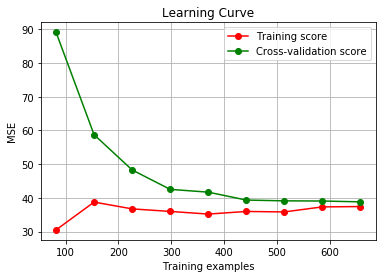

In [20]:
#plot the learning curve, with respect to training examples
learn_curve(regr, training_X, training_y, train_size)

The MSE is high for both the training and validations sets.

This curve reflects high bias in the model, meaning that it underfits.
Some ways to address high bias include: adding additional features, adding polynomial features, if a regularization parameter was used then decreasing the regularization parameter lambda (it was not used in this case).  

**High Bias**: error will be high for the training set and the validation set   
**High Variance**:  error will be low for the training set but much higher for the validation set  

Addressing high bias: additional features, adding polynomial features, decreasing the regularization parameter lambda  
Addressing high variance: additional training examples, smaller set of features, increase the regularization parameter lambda

** Address bias in the model by adding polynomial features **

In [21]:
#get polynomial function of order 2
poly = PolynomialFeatures(2)

#interaction terms only
#poly = PolynomialFeatures(degree=3, interaction_only=True)

In [22]:
#apply polynomial transform to get polynomial features
train_polyFit = poly.fit_transform(train_X_scaled) 
validation_polyFit = poly.fit_transform(validation_X_scaled) 
training_polyFit =  poly.fit_transform(training_X_scaled) 
test_polyFit = poly.fit_transform(test_X_scaled)

In [23]:
train_polyFit.shape, validation_polyFit.shape, training_polyFit.shape, test_polyFit.shape

((721, 231), (181, 231), (902, 231), (226, 231))

In [24]:
#View features
poly_features = poly.fit(training_X_scaled)
poly_features.get_feature_names(X.columns)

['1',
 'consignee_name_nunique',
 'shipper_party_name_nunique',
 'shipper_consigner_nunique',
 'container_number_nunique',
 'identifier_count',
 'piece_count_sum',
 'shipment_count',
 'top5_carrier',
 'month_est_1',
 'month_est_2',
 'month_est_3',
 'month_est_4',
 'month_est_5',
 'month_est_6',
 'month_est_7',
 'month_est_8',
 'month_est_9',
 'month_est_10',
 'month_est_11',
 'month_est_12',
 'consignee_name_nunique^2',
 'consignee_name_nunique shipper_party_name_nunique',
 'consignee_name_nunique shipper_consigner_nunique',
 'consignee_name_nunique container_number_nunique',
 'consignee_name_nunique identifier_count',
 'consignee_name_nunique piece_count_sum',
 'consignee_name_nunique shipment_count',
 'consignee_name_nunique top5_carrier',
 'consignee_name_nunique month_est_1',
 'consignee_name_nunique month_est_2',
 'consignee_name_nunique month_est_3',
 'consignee_name_nunique month_est_4',
 'consignee_name_nunique month_est_5',
 'consignee_name_nunique month_est_6',
 'consignee_na

In [25]:
#save all sets to a file to use the same sets in other models
np.save('D:/CUNY Files/capstone/code files/train_polyFit_v.npy', train_polyFit)

In [26]:
np.save('D:/CUNY Files/capstone/code files/validation_polyFit_v.npy', validation_polyFit)

In [27]:
np.save('D:/CUNY Files/capstone/code files/training_polyFit_v.npy',training_polyFit)

In [28]:
np.save('D:/CUNY Files/capstone/code files/test_polyFit_v.npy',test_polyFit)

** Implement a Linear Regression with scaled polynomial features, without regularization **

In [29]:
#create a linear regression
regr_poly = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

In [30]:
#fit the regression model
regr_poly.fit(train_polyFit, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
#get intercept and coefficients
print('Intercept: \n', regr_poly.intercept_)
print('Coefficients: \n', regr_poly.coef_)

Intercept: 
 [ -7.65623235e+11]
Coefficients: 
 [[ -1.67107811e-11   8.07728396e+00   1.31058268e+01  -1.70236065e+01
    1.27353891e+01  -3.36803627e+00   1.27046243e+00  -2.44740707e+01
    5.06420027e+10  -4.89256885e+10   1.30247635e+11   1.23485657e+11
   -4.67536886e+10  -4.52979746e+10   4.02491632e+09  -4.57044799e+10
    4.67506332e+09  -6.98816208e+10  -6.08941211e+10  -3.61541551e+10
    9.80646387e+10  -8.44268503e+01   1.50729887e+02   3.01611302e+01
    5.63083196e+00  -1.42541037e+01  -1.92153778e+01  -2.47094303e-01
   -3.86533260e+00   6.01059011e+08   5.71830342e+08   5.54109602e+08
    6.24510541e+08   5.80402657e+08   6.35737008e+08   5.67473834e+08
    5.76139596e+08   5.58614642e+08   5.40277655e+08   5.21042940e+08
    5.16082335e+08  -1.50602445e+02   1.53361579e+02  -3.93432754e+01
    3.96844027e+01  -2.16174936e+01   1.84241145e+01   5.87131023e+00
    8.14281614e+07   7.74684179e+07   7.50677150e+07   8.46052476e+07
    7.86297466e+07   8.61261461e+07   7.68

** Evaluate the model with polynomial features **

In [32]:
#predict the target values of the validation set using the model
validation_y_poly_pred = regr_poly.predict(validation_polyFit)

In [35]:
#Evaluate the MSE on the validation set
round(mean_squared_error(validation_y, validation_y_poly_pred),2)

45.409999999999997

The error is higher than in the non-polynomial regression  
try regularization with ridge regression and then Lasso Regression

** Regularize with Ridge Regression (Linear least squares with l2 regularization) **

In [36]:
#set up the ridge model
ridge = Ridge(alpha=1.0, fit_intercept=True, normalize=True, copy_X=True, max_iter=1000, tol=0.001, solver='auto', random_state=rand)

In [37]:
#fit the ridge model
ridge.fit(train_polyFit, train_y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, random_state=15, solver='auto', tol=0.001)

** Evaluate the ridge model **

In [38]:
#predict the target values of the validation set using the model
validation_y_ridge_pred = ridge.predict(validation_polyFit)

In [39]:
#Evaluate the MSE on the validation set
round(mean_squared_error(validation_y, validation_y_ridge_pred),2)

27.82

This is slightly higher than linear regression without polynomials

** Regularize with Lasso Regression (Linear Model trained with L1 prior as regularizer) **

In [40]:
#set up the lasso model
lasso = Lasso(alpha=1.0, fit_intercept=True, normalize=True, precompute=False, copy_X=True, max_iter=2500, tol=0.0001, warm_start=False, positive=False, random_state=rand, selection='cyclic')

In [41]:
#fit the lasso model
lasso.fit(train_polyFit, train_y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=2500,
   normalize=True, positive=False, precompute=False, random_state=15,
   selection='cyclic', tol=0.0001, warm_start=False)

** Evaluate the Lasso model **

In [42]:
#predict the target values of the validation set using the model
validation_y_lasso_pred = lasso.predict(validation_polyFit)

In [43]:
#Evaluate the MSE on the validation set
round(mean_squared_error(validation_y, validation_y_lasso_pred),2)

27.260000000000002

The MSE is slightly lower than the non-polynomial regression and ridege regression

** Consider alternate values of alpha (regularization strength) for the Ridge regularization **

In [44]:
def valid_curve(model,X,y):
    #Use full training set (train + validation and implement k-folds)
    #create a learning curve: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve
    train_scores, validation_scores = validation_curve(
        model, X, y, param_name = "alpha", 
        param_range = alpha_range, groups=None, cv=cv, 
        scoring= mse_scorer, n_jobs=1, pre_dispatch='all', verbose=0)
    #get the mean of the training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    #plot the chart
    plt.figure()
    plt.title('Validation Curve')
    plt.xlabel("Alpha - regularization strength")
    plt.ylabel("MSE")
    plt.ticklabel_format(useOffset=False,style='plain')
    #plt.ylim(6, 8)

    plt.grid()

    plt.plot(alpha_range, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(alpha_range, validation_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="best")

In [45]:
#set up the range for alpha values
alpha_range = np.arange(0.1, 10, 0.2)
alpha_range

array([ 0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9,  2.1,
        2.3,  2.5,  2.7,  2.9,  3.1,  3.3,  3.5,  3.7,  3.9,  4.1,  4.3,
        4.5,  4.7,  4.9,  5.1,  5.3,  5.5,  5.7,  5.9,  6.1,  6.3,  6.5,
        6.7,  6.9,  7.1,  7.3,  7.5,  7.7,  7.9,  8.1,  8.3,  8.5,  8.7,
        8.9,  9.1,  9.3,  9.5,  9.7,  9.9])

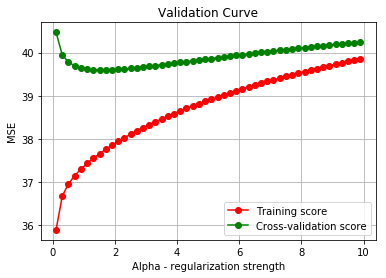

In [46]:
#plot the validation curve with a range of alpha values
valid_curve(ridge, training_polyFit, training_y)

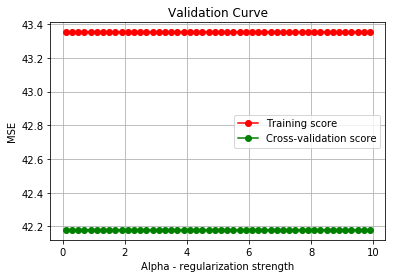

In [47]:
#plot the validation curve with a range of alpha values
valid_curve(lasso, training_polyFit, training_y)

The training and validation set MSE are pretty close for all values of alpha, reducing alpha to 0.1 would reduce the MSE slightly, but there aren't large differences between alpha = 0.1 and alpha = 1.0

** Test the model on the test set **

In [48]:
#predict the target values of the validation set using the model
test_y_pred = regr.predict(test_X_scaled)

In [49]:
#Evaluate the MSE on the validation set
round(mean_squared_error(test_y, test_y_pred),2)

27.5

** Save the model to test later **

In [ ]:
# save the model
filename = 'ridge_polynomial_regresion.sav'
pickle.dump(ridge, open(filename, 'wb'))

In [ ]:
'''
to reload model:
# load the model from disk
filename = 'ridge_polynomial_regresion.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
'''